### Plot depth from above

Image sape: (720, 1280, 3), Depth shape: (720, 1280)


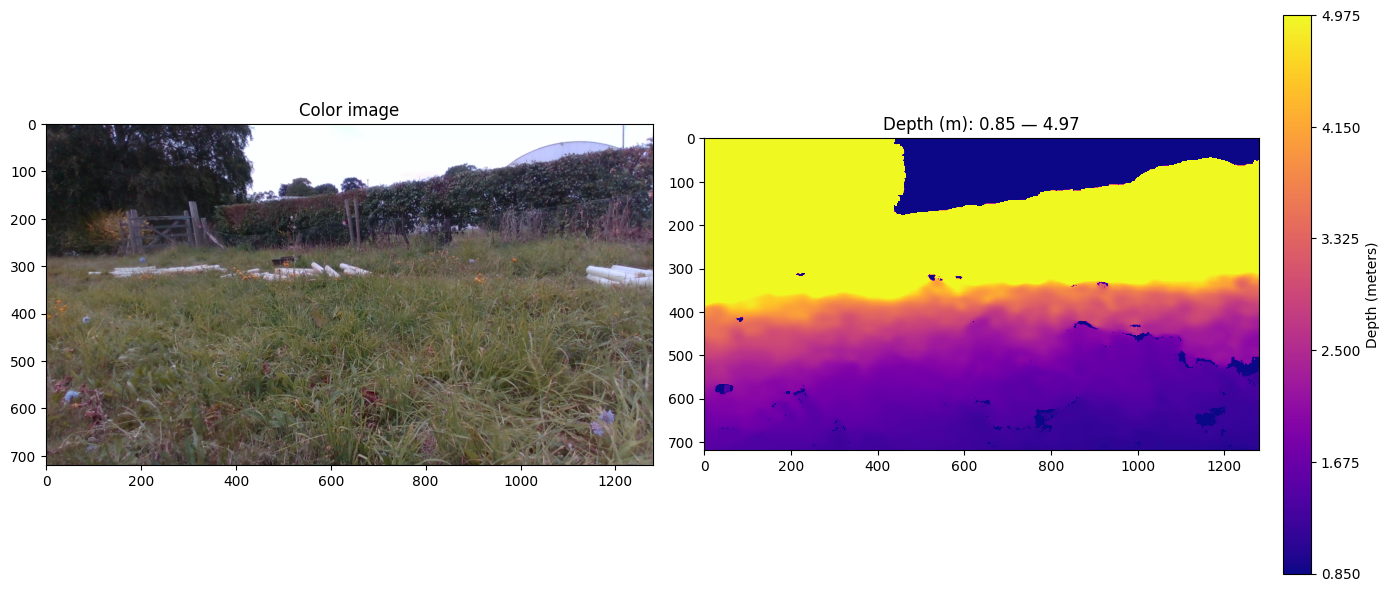

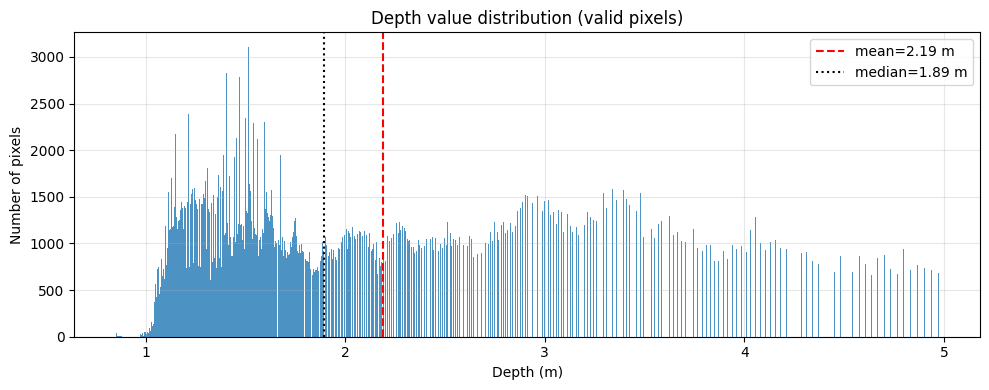

In [1]:
import numpy as np
import os
import cv2 
from PIL import Image
import matplotlib.pyplot as plt

image_path = "/home/ale_navone/ws_pytorch/GAIA/snapViT/data/new/scene_0002/ugv_images/frame_1722603591_1909.png"
depth_path = "/home/ale_navone/ws_pytorch/GAIA/snapViT/data/new/scene_0002/ugv_depths/frame_1722603591_1909.png"
intrinsics_matrix = [[908.9019165039062, 0, 650.3306884765625], [0, 909.1548461914062, 363.9925537109375], [0, 0, 1]]

# Load color image
color_image = Image.open(image_path)
color_image = np.array(color_image)

# Load depth image
depth_image = Image.open(depth_path)
depth_image = np.array(depth_image)
depth_image = depth_image.astype(np.float32) / 1000.0  # Convert mm to meters
print(f"Image sape: {color_image.shape}, Depth shape: {depth_image.shape}")

# mask invalid (zero) depths if present
valid_mask = (depth_image > 0) & (depth_image < 5.0)
if np.any(valid_mask):
    dmin = float(np.nanmin(np.where(valid_mask, depth_image, np.nan)))
    dmax = float(np.nanmax(np.where(valid_mask, depth_image, np.nan)))
else:
    dmin, dmax = float(np.min(depth_image)), float(np.max(depth_image))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# show color image
axes[0].imshow(color_image)
axes[0].set_title('Color image')

# show depth image with colorbar and range ticks
im = axes[1].imshow(depth_image, cmap='plasma', vmin=dmin, vmax=dmax)
axes[1].set_title(f'Depth (m): {dmin:.2f} — {dmax:.2f}')
cbar = fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
ticks = np.linspace(dmin, dmax, 6)
cbar.set_ticks(ticks)
cbar.set_label('Depth (meters)')

plt.tight_layout()
plt.show()
# plot distribution of valid depth values
if np.any(valid_mask):
  depths = depth_image[valid_mask].ravel()
else:
  depths = depth_image.ravel()

plt.figure(figsize=(10, 4))
plt.hist(depths, bins=1000, range=(dmin, dmax), color='tab:blue', alpha=0.8)
plt.xlabel('Depth (m)')
plt.ylabel('Number of pixels')
plt.title('Depth value distribution (valid pixels)')
plt.axvline(depths.mean(), color='r', linestyle='--', label=f'mean={depths.mean():.2f} m')
plt.axvline(np.median(depths), color='k', linestyle=':', label=f'median={np.median(depths):.2f} m')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()




/tmp/ipykernel_338870/2247143699.py:78: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = plt.scatter(Z, -Y, c=colors, cmap='viridis', s=0.6, marker='.', linewidths=0)


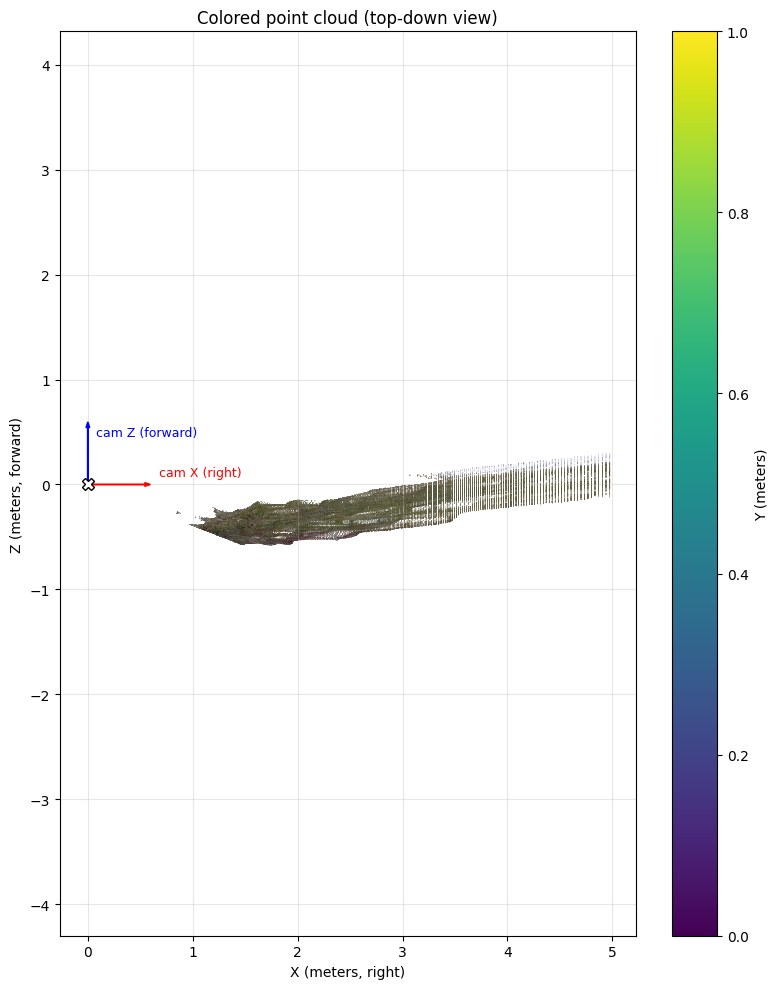

In [ ]:
# Bird's-eye colored point cloud (top-down / above view)
# Uses: depth_image, color_image, intrinsics_matrix, valid_mask, np, plt (already in notebook)

intr = np.array(intrinsics_matrix)
fx, fy = intr[0, 0], intr[1, 1]
cx, cy = intr[0, 2], intr[1, 2]

h, w = depth_image.shape
u_grid, v_grid = np.meshgrid(np.arange(w), np.arange(h))  # shape (h, w)

# Flatten and keep only valid points
depth_flat = depth_image.ravel()
mask_flat = valid_mask.ravel()
u_flat = u_grid.ravel()
v_flat = v_grid.ravel()

u_f = u_flat[mask_flat]
v_f = v_flat[mask_flat]
z_f = depth_flat[mask_flat]

# 3D camera coordinates
x_f = (u_f - cx) * z_f / fx
y_f = (v_f - cy) * z_f / fy
# For a top-down view we typically use X (lateral) and Z (forward) axes:
X = -x_f
Y =  y_f
Z = z_f

# Colors for each point
colors = color_image.reshape(-1, 3)[mask_flat] / 255.0

# Subsample if too many points for plotting
#max_pts = 200000
#n_pts = X.shape[0]
#if n_pts > max_pts:
#    idx = np.random.default_rng(0).choice(n_pts, size=max_pts, replace=False)
#    X = X[idx]
#    Z = Z[idx]
#    colors = colors[idx]
#

# prepare camera-axis drawing to run after the figure is created
_axis_len = max(np.nanmax(np.abs(X)), np.nanmax(np.abs(Z)), 1.0) * 0.12
_cam_origin = (0.0, 0.0)  # in camera coords (X, Z)
_x_end = (_cam_origin[0] + _axis_len, _cam_origin[1])
_z_end = (_cam_origin[0], _cam_origin[1] + _axis_len)

_original_show = plt.show

def _show_with_cam_axes(*args, **kwargs):
    ax = plt.gca()
    # draw camera axes (X -> right, Z -> forward)
    ax.arrow(_cam_origin[0], _cam_origin[1],
             _x_end[0] - _cam_origin[0], _x_end[1] - _cam_origin[1],
             color='red', width=_axis_len * 0.01, head_width=_axis_len * 0.06,
             length_includes_head=True, zorder=20)
    ax.annotate('cam X (right)', (_x_end[0], _x_end[1]),
                color='red', fontsize=9, xytext=(6, 6), textcoords='offset points', zorder=21)
    ax.arrow(_cam_origin[0], _cam_origin[1],
             _z_end[0] - _cam_origin[0], _z_end[1] - _cam_origin[1],
             color='blue', width=_axis_len * 0.01, head_width=_axis_len * 0.06,
             length_includes_head=True, zorder=20)
    ax.annotate('cam Z (forward)', (_z_end[0], _z_end[1]),
                color='blue', fontsize=9, xytext=(6, -10), textcoords='offset points', zorder=21)
    # mark camera origin
    ax.plot(_cam_origin[0], _cam_origin[1], marker='X', color='white', markeredgecolor='black',
            markersize=8, zorder=22)
    ax.annotate('camera', _cam_origin, color='white', fontsize=9, xytext=(6, -6), textcoords='offset points', zorder=23)
    # call original show
    _original_show(*args, **kwargs)
    # restore original show to avoid double-wrapping if executed again
    plt.show = _original_show

# replace plt.show with our wrapper so axes get drawn when the cell calls plt.show()
plt.show = _show_with_cam_axes

plt.figure(figsize=(8, 10))
sc = plt.scatter(X, Z, c=colors, cmap='viridis', s=0.6, marker='.', linewidths=0)
plt.colorbar(sc, label='Y (meters)')
plt.xlabel('X (meters, right)')
plt.ylabel('Z (meters, forward)')
plt.title('Colored point cloud (top-down view)')
plt.grid(alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

World to camera matrix:
[[-0.         -0.         -1.          1.        ]
 [-0.97865396 -0.20551505 -0.          1.98017299]
 [-0.20551505  0.97865396  0.          3.78693833]
 [ 0.          0.          0.          1.        ]]
Changed world to camera matrix:
[[-0.97865396 -0.20551505 -0.          1.98017299]
 [-0.         -0.         -1.          1.        ]
 [-0.20551505  0.97865396  0.          3.78693833]
 [ 0.          0.          0.          1.        ]]
Camera to world matrix:
[[-0.97865396 -0.         -0.20551505  2.71617695]
 [-0.20551505  0.          0.97865396 -3.29914683]
 [-0.         -1.         -0.          1.        ]
 [ 0.          0.          0.          1.        ]]
Translation vector: [[ 2.71617695]
 [-3.29914683]
 [ 1.        ]]
Camera position in world coordinates: x=2.72, y=-3.30, z=1.00


/tmp/ipykernel_338870/1095046767.py:46: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = plt.scatter(Xw, Yw, c=colors, cmap='viridis', s=0.6, marker='.', linewidths=0)


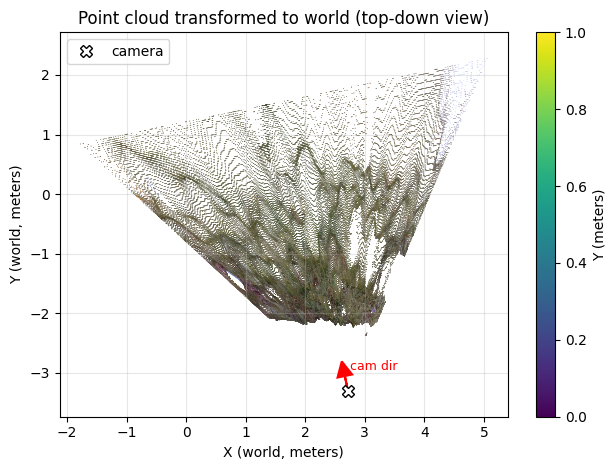

In [3]:
from matplotlib.lines import Line2D


matrix_w2c = [[  -0.0,  -0.0,  -1.0,  1.0],[  -0.9786539555169959,  -0.20551504896463935,  -0.0,  1.9801729908914827],[  -0.20551504896463932,  0.9786539555169956,  0.0,  3.7869383286468876],[  0.0,  0.0,  0.0,  1.0]]
matrix_w2c = np.array(matrix_w2c)
print("World to camera matrix:")
print(matrix_w2c)

def change_matrix(mat):
    # Swap rows 1 and 2
    mat[[0, 1]] = mat[[1, 0]]
    return mat

matrix_w2c = change_matrix(matrix_w2c)
print(f"Changed world to camera matrix:\n{matrix_w2c}")
# Invert to get camera-to-world
matrix_c2w = np.linalg.inv(matrix_w2c)
#matrix_c2w[1, 3] = -matrix_c2w[1, 3]  # Negate Y translation to account for row swap
print("Camera to world matrix:")
print(matrix_c2w)

# Transform camera points to world coordinates and plot top-down view
pts_cam = np.vstack([X, Y, Z, np.ones_like(X)])  # shape (4, N)
pts_world = matrix_c2w @ pts_cam  # (4, N)
pts_world = pts_world[:3, :]  # keep only XYZ
print(f"Translation vector: {matrix_c2w[:3, 3:4]}")

Xw = pts_world[0, :]
Yw = pts_world[1, :]
Zw = pts_world[2, :]

x_cam, y_cam = matrix_c2w[:3, 3][:2] 
z_dir = matrix_c2w[:3, 2]
cam_dir_x = z_dir[0]
cam_dir_y = z_dir[1]

endpoint_x = x_cam + cam_dir_x * 0.5
endpoint_y = y_cam + cam_dir_y * 0.5

dir_points = np.array([[x_cam, y_cam], [endpoint_x, endpoint_y]])

ax = plt.gca()
cam_pos = matrix_c2w[:3, 3]
print(f"Camera position in world coordinates: x={cam_pos[0]:.2f}, y={cam_pos[1]:.2f}, z={cam_pos[2]:.2f}")

sc = plt.scatter(Xw, Yw, c=colors, cmap='viridis', s=0.6, marker='.', linewidths=0)
# plot camera direction arrow in the same world->plot coordinate frame (x=Yw, y=-Xw)
cam_plot_x = x_cam
cam_plot_y = y_cam
end_plot_x = endpoint_x
end_plot_y = endpoint_y

dx = end_plot_x - cam_plot_x
dy = end_plot_y - cam_plot_y

ax.arrow(cam_plot_x, cam_plot_y, dx, dy,
         color='red', head_width=0.25, head_length=0.25,
         linewidth=1.5, length_includes_head=True, zorder=30)
ax.plot(cam_plot_x, cam_plot_y, marker='X', color='white',
        markeredgecolor='black', markersize=8, zorder=31, label='camera')
ax.annotate('cam dir', (end_plot_x, end_plot_y), color='red',
            fontsize=9, xytext=(6, -6), textcoords='offset points')
plt.colorbar(sc, label='Y (meters)')
plt.xlabel('X (world, meters)')
plt.ylabel('Y (world, meters)')
plt.title('Point cloud transformed to world (top-down view)')
plt.grid(alpha=0.3)
plt.legend()
plt.axis('equal')
plt.tight_layout()
plt.show()

1369 1369


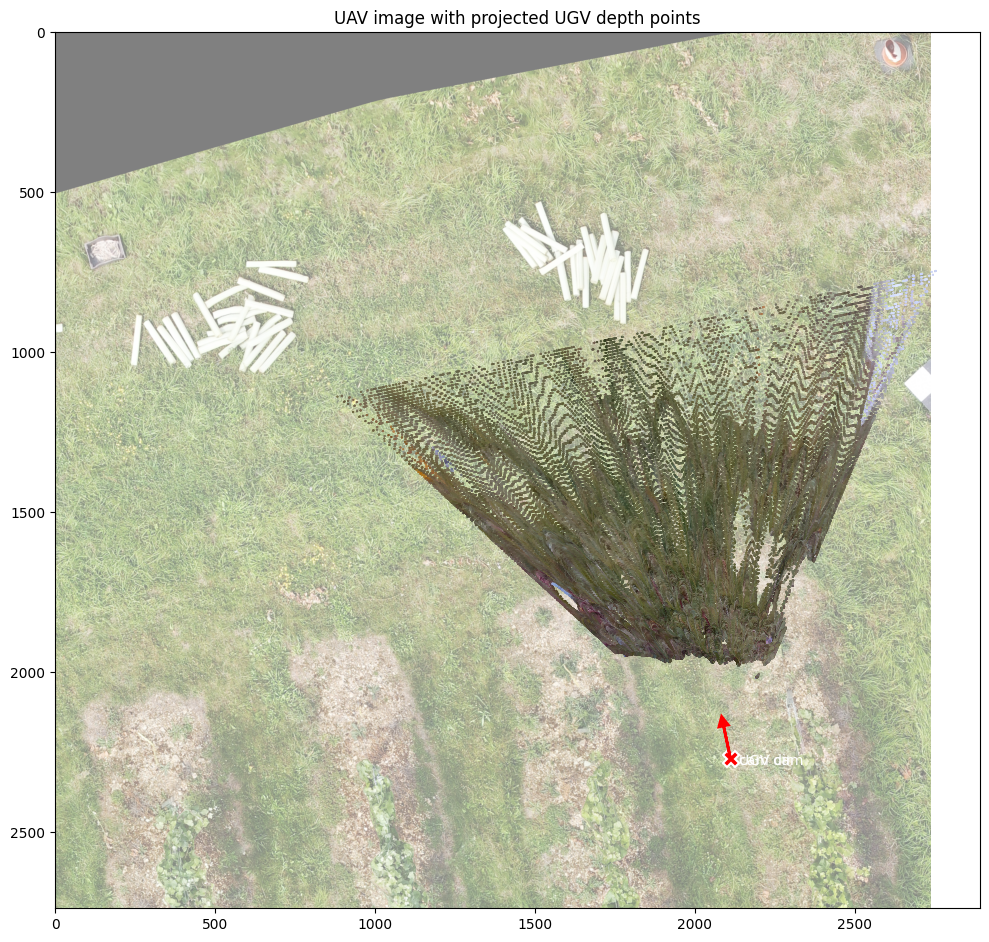

In [4]:
uav_img = Image.open("/home/ale_navone/ws_pytorch/GAIA/snapViT/data/new/scene_0002/uav_image/tile_0_5476.png")
uav_img = np.array(uav_img)
#rotate uav image 90 degrees counterclockwise
img_w, img_h = uav_img.shape[1], uav_img.shape[0]
tile_size = 10.0 # meters
pixels_per_meter = img_w / tile_size  # assuming square image
center_x = uav_img.shape[1] // 2
center_y = uav_img.shape[0] // 2

# Convert world coordinates to UAV image pixel coordinates
uav_u = (Xw * pixels_per_meter).astype(int) + center_x
uav_v = -(Yw * pixels_per_meter).astype(int) + center_y      
print(center_x, center_y)  
#plot uav image with low alpha
plt.figure(figsize=(10, 10))
plt.imshow(uav_img, alpha=0.5)
plt.scatter(uav_u, uav_v, c=colors, s=0.5, marker='.', linewidths=1)

# Plot camera position on UAV image
cam_u = int(cam_pos[0] * pixels_per_meter) + center_x   
cam_v = -int(cam_pos[1] * pixels_per_meter) + center_y

dx = end_plot_x - cam_plot_x
dy = end_plot_y - cam_plot_y

# convert to pixel delta using same scale as cam_u/cam_v
dx_pix = int(dx * pixels_per_meter)
dy_pix = -int(dy * pixels_per_meter)


# draw arrow on the UAV image plot
plt.arrow(cam_u, cam_v, dx_pix, dy_pix,
          color='red', head_width=30, head_length=30, linewidth=2,
          length_includes_head=True, zorder=12)
plt.annotate('cam dir', (cam_u, cam_v), color='white', fontsize=10,
             ha='left', va='bottom', xytext=(6, -6), textcoords='offset points', zorder=13)

# Check bounds and plot marker + label
if 0 <= cam_u < uav_img.shape[1] and 0 <= cam_v < uav_img.shape[0]:
    plt.plot(cam_u, cam_v, marker='X', color='red', markersize=12,
             markeredgecolor='white', markeredgewidth=1.5, zorder=10)
    plt.annotate('UGV cam', (cam_u, cam_v), color='white', fontsize=10,
                 ha='left', va='bottom', xytext=(6, -6), textcoords='offset points', zorder=11)
else:
    print(f'Camera projected outside UAV image at ({cam_u}, {cam_v})')
plt.title('UAV image with projected UGV depth points')
plt.tight_layout()
plt.show()

In [5]:
m = [[-0.,         -0.,         -1.,          1.,        ],
 [ 0.98447588,  0.17551992,  0.0,          5.01109557],
 [ 0.17551992, -0.98447588, -0.,         -4.12300722],
 [ 0.,          0.,          0.,          1.,        ]]


m_inv = np.linalg.inv(np.array(m))
print(m_inv)
change_matrix(np.array(m))
m_changed = change_matrix(np.array(m))
m_changed_inv = np.linalg.inv(m_changed)
print(m_changed_inv)

[[ 0.          0.98447588  0.17551992 -4.20963282]
 [-0.          0.17551992 -0.98447588 -4.93854825]
 [-1.         -0.         -0.          1.        ]
 [ 0.          0.          0.          1.        ]]
[[ 0.98447588  0.          0.17551992 -4.20963282]
 [ 0.17551992 -0.         -0.98447588 -4.93854825]
 [-0.         -1.         -0.          1.        ]
 [ 0.          0.          0.          1.        ]]
